We now run freemuxlet on all samples. We need freemuxlet results for the QC.

In [18]:
nwork=${VSC_SCRATCH}/hca_benchmark_freemuxlet_libds/
mkdir $nwork
export NXF_WORK=$nwork
module load Nextflow
VSN=/staging/leuven/stg_00002/lcb/cflerin/testruns/vib-singlecell-nf/vsn__develop_atac/vsn-pipelines/main.nf

mkdir: cannot create directory ‘/scratch/leuven/330/vsc33042/hca_benchmark_freemuxlet_libds/’: File exists


In [6]:
nextflow config $VSN \
    -profile bam,tsv,popscle,vsc \
    > vsn_freemuxlet.config

* change vcf to `vcf = '/staging/leuven/stg_00002/lcb/cflerin/data/public/1000G/1000Genomes.wgs.GRCH38.sites.minAF-0.1.freemuxlet-scATAC.vcf.gz'`
* change tsv paths to `file_paths = out_qc_all/data/pycistopic/qc/selected_barcodes/*.cell_barcodes.txt'`
* change bam paths to ` file_paths = '/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc_atac/analysis2/data_freeze_Jun2021/atac_preprocess/multiplet_tagged/bam/*_1.bwa.out.possorted.mm.bam,/staging/leuven/stg_00002/lcb/cflerin/analysis/pbmc_atac/analysis2/data_freeze_Jun2021/atac_preprocess/multiplet_tagged/bam/*_2.bwa.out.possorted.mm.bam'`
* change out directory to `out_fmx`
* EXTREMELY IMPORTANT: Change the `barcode_tag = DB`! Otherwise you won't use multiplet merged cell barcodes!

I generate a config for all the hydrop samples. You can also run all samples together.

for hydrop:  
/lustre1/project/stg_00002/lcb/fderop/data/20211008_hca_benchmark_rerun_all_with_hydrop/bams_postbap/VIB_Hydrop_?*  
/lustre1/project/stg_00002/lcb/fderop/data/20211008_hca_benchmark_rerun_all_with_hydrop/out_qc_all/data/pycistopic/qc/selected_barcodes/VIB_Hydrop_?*

In [1]:
cat vsn_freemuxlet.config

manifest {
   name = 'vib-singlecell-nf/vsn-pipelines'
   description = 'A repository of pipelines for single-cell data in Nextflow DSL2'
   homePage = 'https://github.com/vib-singlecell-nf/vsn-pipelines'
   version = '0.27.0'
   mainScript = 'main.nf'
   defaultBranch = 'master'
   nextflowVersion = '!>=21.04.3'
}

params {
   global {
      project_name = 'benchmark_fulldata_fmx'
      outdir = 'out_fmx'
   }
   misc {
      test {
         enabled = false
      }
   }
   utils {
      container = 'vibsinglecellnf/utils:0.4.0'
      file_converter {
         off = 'h5ad'
         tagCellWithSampleId = true
         remove10xGEMWell = false
         useFilteredMatrix = true
         makeVarIndexUnique = false
      }
      publish {
         compressionLevel = 6
         annotateWithBatchVariableName = false
         mode = 'copy'
      }
   }
   tools {
      popscle {
         container = 'vibsinglecellnf/popscle:2021-05-05-da70fc7'
         vcf = '/staging/leuven/stg_00002/lcb/cfle

then, run the pipeline (in tmux):

In [ ]:
nwork=${VSC_SCRATCH}/hca_benchmark_freemuxlet_libds/
mkdir $nwork
export NXF_WORK=$nwork
module load Nextflow
VSN=/staging/leuven/stg_00002/lcb/cflerin/testruns/vib-singlecell-nf/vsn__develop_atac/vsn-pipelines/main.nf

nextflow -C vsn_freemuxlet.config run $VSN -entry freemuxlet

The terminal output should look like so (Running for 2 samples only):

```
[08/67852a] process > freemuxlet:FREEMUXLET:DSC_PILEUP_FILTERED:SC__POPSCLE__PREFILTER_DSC_PILEUP (2) [  0%] 0 of 2
[-        ] process > freemuxlet:FREEMUXLET:DSC_PILEUP_FILTERED:SC__POPSCLE__DSC_PILEUP               -
[-        ] process > freemuxlet:FREEMUXLET:SC__POPSCLE__FREEMUXLET                                   -

------------------------------------------------------------------
 No seed detected in the config
 To ensure reproducibility the seed has been set to 270
------------------------------------------------------------------
```

# now, generate concordance files

In [19]:
module load BCFtools
module load VCFtools

INTERMEDIATE=out_fmx/intermediate
mkdir $INTERMEDIATE

mkdir: cannot create directory ‘out_fmx/intermediate’: File exists


: 1

We now cross-compare all vcfs. First, generate a list of commands using `deconvolute_freemuxlet_results.py`.  
in `deconvolute_freemuxlet_results.py`, we need to change:  
* base dir with output from vsn fmx pipeline
* intermediate output dir
* sample names

need to modify the python script in 3 places so that the base dir etc matches.
* base_dir
* intermediate_dir
* sample_rename dir

In [20]:
cat out_fmx/deconvolute_freemuxlet_results.py

#!/usr/bin/env python3

from itertools import combinations
import os

base_dir = 'out_fmx/out/data'
samples = [
    'Broad_1',
    'Broad_2',
    'Broad_mito_1',
    'Broad_mito_2',
    'CNAG_1',
    'CNAG_2',
    'Sanger_1',
    'Sanger_2',
    'Stanford_1',
    'Stanford_2',
    'VIB_1',
    'VIB_2',
    'VIB_Hydrop_1',
    'VIB_Hydrop_2',
    's3atac',
    ]

f_fmx_vcfs = {
        x: os.path.join(base_dir, x + '_freemuxlet.clust1.vcf.gz') for x in samples
        }


# bcftools filters:
min_DP = 10
min_GQ = 10

fmx_samples = ['CLUST0', 'CLUST1']

intermediate_dir = 'out_fmx/intermediate'

# the file {sample_rename} contains a single line with the new sample name to use in place of the existing CLUST0, CLUST1, etc.

filtered_vcfs = []
for n,(fmxVCFname,fmxVCF) in enumerate(f_fmx_vcfs.items()):
    for sample in fmx_samples:
        f_vcf = f"{fmxVCFname}.{sample}.vcf.gz"
        filtered_vcfs.append(f_vcf)
        cmd = f"bcftools view -s {sample} -i 'MIN(FMT/DP)>{min_DP} & MIN(FMT/

In [29]:
out_fmx/deconvolute_freemuxlet_results.py > out_fmx/vcf_filter_subset_compare.parallel

then, run the resulting file (best to do in terminal, since it outputs a lot of lines)

In [30]:
time cat out_fmx/vcf_filter_subset_compare.parallel | parallel -j 4 --progress

local:4/871/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/872/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/873/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/874/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/875/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/876/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/877/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/878/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/879/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/880/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/881/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/882/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/883/100%/0.6s 
gzip: stdout: Broken pipe

gzip: stdout: Broken pipe
local:4/884/

then, evaluate the output by running `evaluate_genotype_concordances.py`. Change the following:  
* sample names
* intermediate dir
* output dir

In [32]:
out_fmx/evaluate_genotype_concordances.py

Created two files:
	genotype_concordance_nvar.txt
	genotype_concordance_nrd.txt



In [33]:
out_fmx/plot_heatmap.py --input out_fmx/genotype_concordance_nrd.txt --output out_fmx/genotype_concordance_heatmap.pdf

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


now, r script. I need to manually insert the concordance of the clusters:
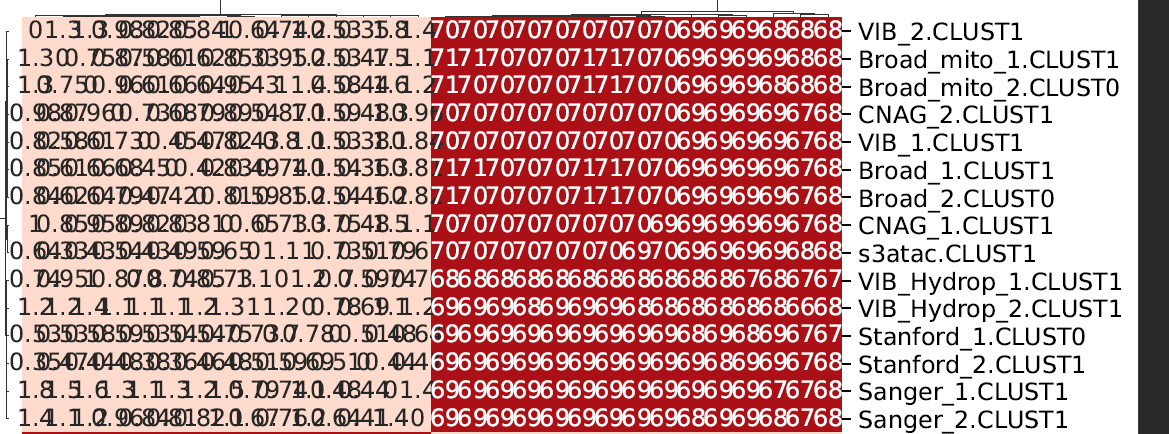

becomes in genotype_concordance_pairings.R: 
```
sampleA = list(
    c('Broad_1',1),
    c('Broad_2',0),
    c('Broad_mito_1',1),
    c('Broad_mito_2',0),
    c('CNAG_1',1),
    c('CNAG_2',1),
    c('Sanger_1',1),
    c('Sanger_2',1),
    c('Stanford_1',0),
    c('Stanford_2',1),
    c('VIB_1',1),
    c('VIB_2',1),
    c('VIB_Hydrop_1',1),
    c('VIB_Hydrop_2',1),
    c('s3atac',1)
)

```

launch R using the following repo

In [ ]:
singularity run --cleanenv -H $PWD -B /lustre1,/staging,${VSC_SCRATCH}/tmp:/tmp /staging/leuven/stg_00002/lcb/cflerin/containers/cflerin-seurat-4.0.3-plus.sif 

then run `genotype_concordance_pairings.R`
* modify f_fmx_dir
* samples
* of course concordance in sampleA
* output in write.table()

In [36]:
cat out_fmx/genotype_concordance_pairings.R

f_fmx_dir = 'out_fmx/data/freemuxlet/'

samples = c(
    'Broad_1',
    'Broad_2',
    'Broad_mito_1',
    'Broad_mito_2',
    'CNAG_1',
    'CNAG_2',
    'Sanger_1',
    'Sanger_2',
    'Stanford_1',
    'Stanford_2',
    'VIB_1',
    'VIB_2',
    'VIB_Hydrop_1',
    'VIB_Hydrop_2',
    's3atac'
    )

f_fmx = sapply(samples, function(s) paste0(f_fmx_dir,s,'_freemuxlet.clust1.samples.gz'))

fmx = lapply(f_fmx, read.delim, sep='\t', stringsAsFactors=FALSE)

# assign unique barcode:
for(i in 1:length(fmx)) {
    fmx[[i]]$ubarcode = paste(names(fmx)[i], "#", fmx[[i]]$BARCODE, sep="")
    fmx[[i]]$replicate = names(fmx)[i]
}


################################################################################
# freemuxlet sample pairing
################################################################################

# these groupings are made manually:
# based on the CLUST? in the heatmap

sampleA = list(
    c('Broad_1',1),
    c('Broad_2',0),
    c('Broad_mito_1',1),
    c('Broad_mito_2',

the output `genotype_concordance_unified.txt` will be used to analyse freemuxlet doublets.